In [2]:
# imports
import os
from io import open
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


In [33]:
# 데이터 불러오기
data = pd.read_csv('C:/Users/82106/Desktop/데이터 분석 프로젝트 2/데이콘 빅데이터 분석/data/한국전력거래소_시간별 신재생에너지 거래량_20220331.csv',encoding='cp949')

In [4]:
# '거래일' 열을 datetime 형식으로 변환
data['거래일'] = pd.to_datetime(data['거래일'], format='%Y-%m-%d')

# '거래일' 열을 float 형식으로 변환 (시간 차이를 일 단위로 변환)
reference_date = data['거래일'].min()
data['거래일'] = (data['거래일'] - reference_date).dt.total_seconds() / (24 * 3600)

In [5]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 정규화된 데이터를 DataFrame으로 변환
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)


### 신재생 에너지 합계

In [6]:
# 학습 데이터와 테스트 데이터 분할 (80:20)
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

# 입력 데이터와 타깃 데이터 분리
train_X = train_data.drop('신재생 합계', axis=1).values
train_y = train_data['신재생 합계'].values
test_X = test_data.drop('신재생 합계', axis=1).values
test_y = test_data['신재생 합계'].values

In [7]:
# 입력 데이터 형식 변환
time_steps = 1
train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Sequential 모델 초기화
model = Sequential()

# LSTM 레이어 추가
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50))

# Dense 레이어 추가
model.add(Dense(1))

c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 모델 학습
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/100
2246/2246 - 13s - 6ms/step - loss: 1.5987e-04 - val_loss: 0.0024
Epoch 2/100
2246/2246 - 6s - 3ms/step - loss: 2.2947e-05 - val_loss: 0.0014
Epoch 3/100
2246/2246 - 6s - 3ms/step - loss: 1.2353e-05 - val_loss: 6.0433e-04
Epoch 4/100
2246/2246 - 6s - 3ms/step - loss: 8.6875e-06 - val_loss: 3.7677e-04
Epoch 5/100
2246/2246 - 5s - 2ms/step - loss: 6.3511e-06 - val_loss: 2.5972e-04
Epoch 6/100
2246/2246 - 6s - 3ms/step - loss: 5.0075e-06 - val_loss: 2.1805e-04
Epoch 7/100
2246/2246 - 6s - 3ms/step - loss: 4.6670e-06 - val_loss: 1.7426e-04
Epoch 8/100
2246/2246 - 6s - 3ms/step - loss: 4.6777e-06 - val_loss: 1.5008e-04
Epoch 9/100
2246/2246 - 6s - 3ms/step - loss: 4.2276e-06 - val_loss: 1.3456e-04
Epoch 10/100
2246/2246 - 6s - 3ms/step - loss: 3.7603e-06 - val_loss: 1.4276e-04
Epoch 11/100
2246/2246 - 5s - 2ms/step - loss: 3.6906e-06 - val_loss: 1.4415e-04
Epoch 12/100
2246/2246 - 6s - 3ms/step - loss: 3.0990e-06 - val_loss: 1.8321e-04
Epoch 13/100
2246/2246 - 5s - 2ms/step - los

In [19]:
# 모델 평가
loss = model.evaluate(test_X, test_y, verbose=2)
print(f'Test Loss: {loss}')

562/562 - 1s - 1ms/step - loss: 2.5274e-05
Test Loss: 2.527357173676137e-05


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 예측 값 생성
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

2246/2246 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [21]:
# 예측 값을 원래 스케일로 역변환
train_predict_extended = np.zeros((train_predict.shape[0], scaled_data.shape[1]))
train_predict_extended[:, 0] = train_predict[:, 0]
train_predict = scaler.inverse_transform(train_predict_extended)[:, 0]

train_y_extended = np.zeros((train_y.shape[0], scaled_data.shape[1]))
train_y_extended[:, 0] = train_y
train_y_true = scaler.inverse_transform(train_y_extended)[:, 0]

test_predict_extended = np.zeros((test_predict.shape[0], scaled_data.shape[1]))
test_predict_extended[:, 0] = test_predict[:, 0]
test_predict = scaler.inverse_transform(test_predict_extended)[:, 0]

test_y_extended = np.zeros((test_y.shape[0], scaled_data.shape[1]))
test_y_extended[:, 0] = test_y
test_y_true = scaler.inverse_transform(test_y_extended)[:, 0]

In [22]:
# RMSE 계산
train_rmse = np.sqrt(mean_squared_error(train_y_true, train_predict))
test_rmse = np.sqrt(mean_squared_error(test_y_true, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 23.451914167882496
Test RMSE: 18.803998135272828


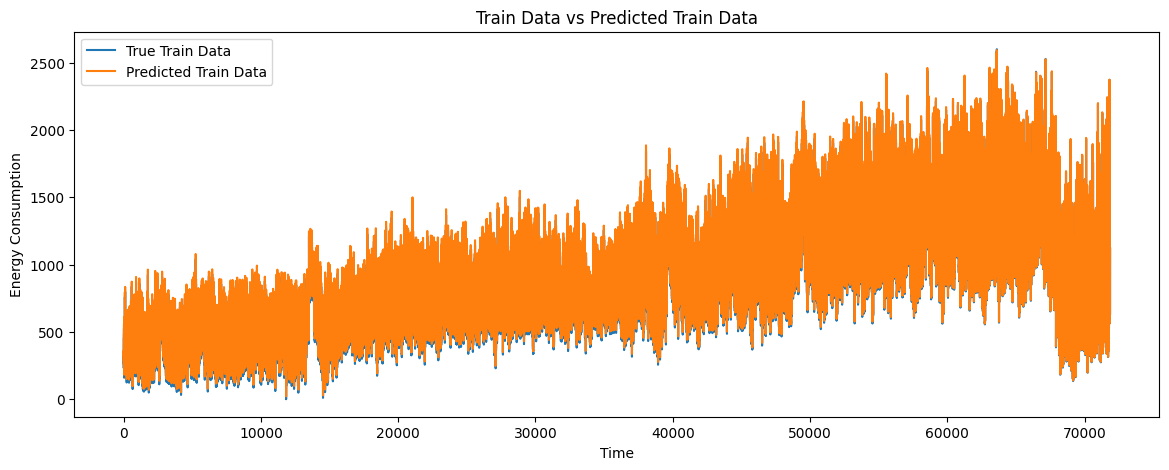

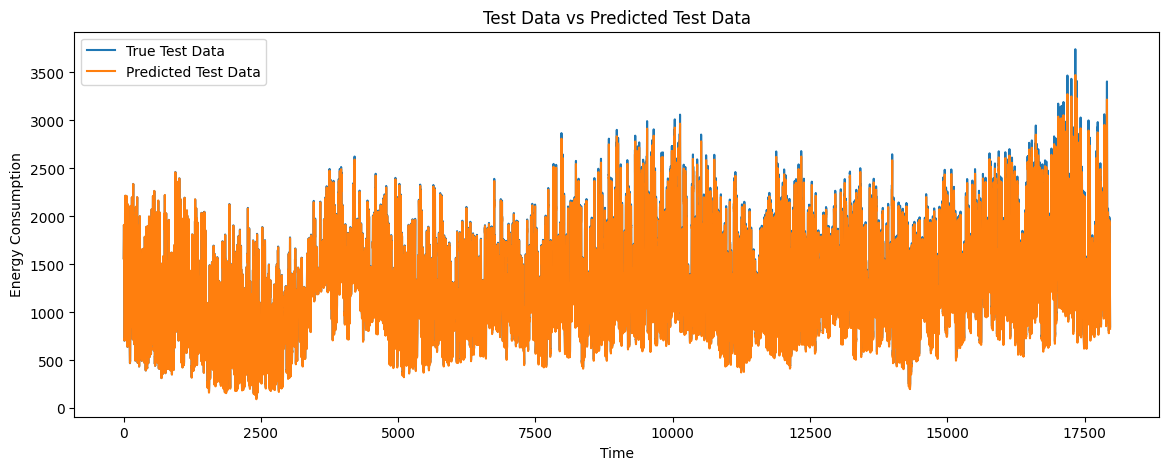

In [23]:
import matplotlib.pyplot as plt

# 결과 시각화
plt.figure(figsize=(14, 5))
plt.plot(train_y_true, label='True Train Data')
plt.plot(train_predict, label='Predicted Train Data')
plt.title('Train Data vs Predicted Train Data')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(test_y_true, label='True Test Data')
plt.plot(test_predict, label='Predicted Test Data')
plt.title('Test Data vs Predicted Test Data')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

### SARMIA

In [4]:
import pandas as pd

# 데이터 불러오기
data = pd.read_csv('C:/Users/82106/Desktop/데이터 분석 프로젝트 2/데이콘 빅데이터 분석/data/한국전력거래소_시간별 신재생에너지 거래량_20220331.csv',encoding='cp949')

In [5]:
# 날짜와 시간을 결합하여 datetime 형식으로 변환
data['datetime'] = pd.to_datetime(data['거래일']) + pd.to_timedelta(data['거래시간'], unit='h')
data.set_index('datetime', inplace=True)

# 특정 에너지원의 데이터 선택 (예: 태양광)
ts_data = data['태양광']

In [6]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터 분할 (75:25)
train_data, test_data = train_test_split(ts_data, test_size=0.25, shuffle=False)

In [7]:
import statsmodels.api as sm
import itertools

# SARIMA 모델의 파라미터 설정
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

best_aic = float("inf")
best_param = None
best_seasonal_param = None

In [8]:
# SARIMA 모델 파라미터 설정
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

In [9]:
# 모델 생성 및 학습
model = sm.tsa.statespace.SARIMAX(train_data,
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()
print(results.summary())

c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                태양광   No. Observations:                67374
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -323352.742
Date:                            Fri, 26 Jul 2024   AIC                         646715.485
Time:                                    21:42:02   BIC                         646761.071
Sample:                                01-01-2012   HQIC                        646729.570
                                     - 09-08-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4813      0.002    240.522      0.000       0.477       0.485
ma.L1          0.4730      0.002   

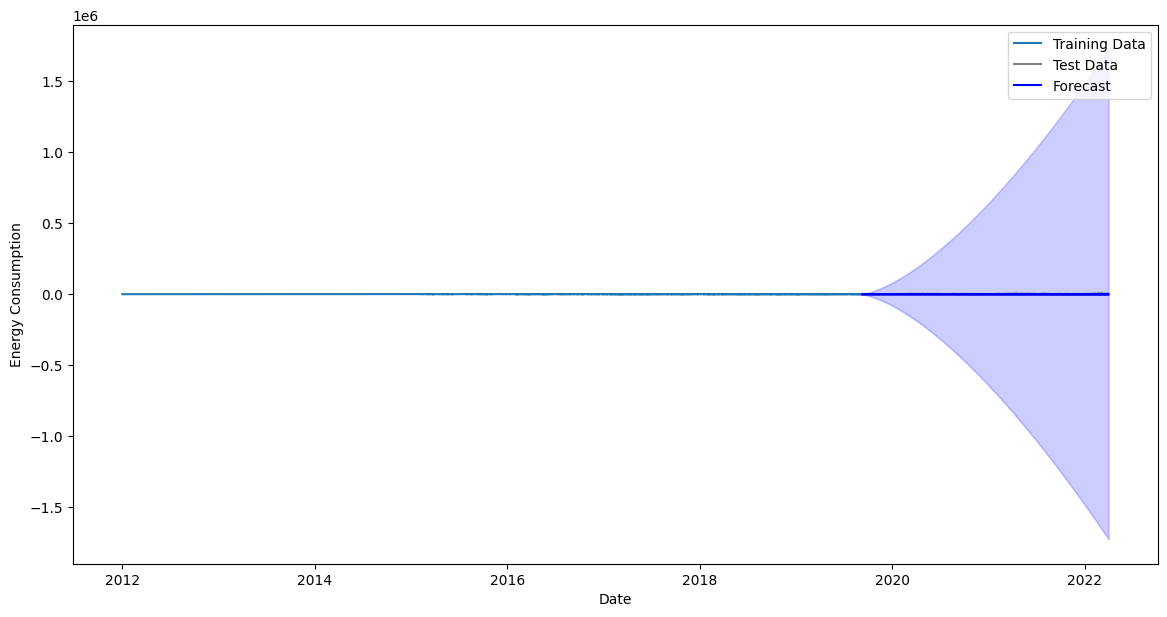

In [10]:
import matplotlib.pyplot as plt

# 예측 값 생성
pred = results.get_forecast(steps=len(test_data))
pred_ci = pred.conf_int()

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data', color='gray')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Forecast', color='blue')
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
